In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/train_data/README.md
/kaggle/input/train-data/train_data/.Rhistory
/kaggle/input/train-data/train_data/video_03/video_left.avi
/kaggle/input/train-data/train_data/video_03/action_discrete.txt
/kaggle/input/train-data/train_data/video_03/action_continuous.txt
/kaggle/input/train-data/train_data/video_03/segmentation/000017040.png
/kaggle/input/train-data/train_data/video_03/segmentation/000020040.png
/kaggle/input/train-data/train_data/video_03/segmentation/000018840.png
/kaggle/input/train-data/train_data/video_03/segmentation/000015840.png
/kaggle/input/train-data/train_data/video_03/segmentation/000011040.png
/kaggle/input/train-data/train_data/video_03/segmentation/000015420.png
/kaggle/input/train-data/train_data/video_03/segmentation/000021480.png
/kaggle/input/train-data/train_data/video_03/segmentation/000008040.png
/kaggle/input/train-data/train_data/video_03/segmentation/000026400.png
/kaggle/input/train-data/train_data/video_03/segmentation/000012060.

In [2]:
!pip install opencv-python
!pip install torchvision
!pip install scikit-learn
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.2 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=fcc9ae805c2b10fa6180801f36c42693b99601b14c1f2bfbb10144064e22e55f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=bbaf0c133edcdbee5eb3370cac10c17b1adf290846da0f8af100ce4e94718170
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [4]:
import os
root_dir = '/kaggle/input/train-data/train_data/'

video_folders = sorted([os.path.join(root_dir, folder) 
                        for folder in os.listdir(root_dir) if folder.startswith("video")])

print("Found video folders:", video_folders)

Found video folders: ['/kaggle/input/train-data/train_data/video_01', '/kaggle/input/train-data/train_data/video_02', '/kaggle/input/train-data/train_data/video_03', '/kaggle/input/train-data/train_data/video_04', '/kaggle/input/train-data/train_data/video_05', '/kaggle/input/train-data/train_data/video_06', '/kaggle/input/train-data/train_data/video_07', '/kaggle/input/train-data/train_data/video_08', '/kaggle/input/train-data/train_data/video_09', '/kaggle/input/train-data/train_data/video_10', '/kaggle/input/train-data/train_data/video_11_1', '/kaggle/input/train-data/train_data/video_11_2', '/kaggle/input/train-data/train_data/video_12', '/kaggle/input/train-data/train_data/video_13', '/kaggle/input/train-data/train_data/video_14', '/kaggle/input/train-data/train_data/video_15_1', '/kaggle/input/train-data/train_data/video_15_2', '/kaggle/input/train-data/train_data/video_16', '/kaggle/input/train-data/train_data/video_17_1', '/kaggle/input/train-data/train_data/video_17_2', '/kagg

In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, frame_dir, mask_dir, transform_frame=None, transform_mask=None):
        self.frame_dir = frame_dir
        self.mask_dir = mask_dir
        self.frame_files = sorted(os.listdir(frame_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform_frame = transform_frame
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frame_dir, self.frame_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        frame = Image.open(frame_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform_frame:
            frame = self.transform_frame(frame)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return frame, mask

In [6]:
import torch
import numpy as np
from torch.utils.data import ConcatDataset
import torchvision.transforms as T
from PIL import Image

frame_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Map unique labels to contiguous range [0, num_classes - 1]
def remap_mask(mask):
    unique_labels = np.unique(mask)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    remapped_mask = np.vectorize(label_mapping.get)(mask)
    return remapped_mask

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=Image.NEAREST),
    T.Lambda(lambda x: torch.from_numpy(remap_mask(np.array(x))).long())  
])

# Combine datasets from all video folders
datasets = []
for video_folder in video_folders:
    frame_dir = os.path.join(video_folder, "frames")
    mask_dir = os.path.join(video_folder, "segmentation")
    
    if os.path.exists(frame_dir) and os.path.exists(mask_dir):
        datasets.append(CustomDataset(
            frame_dir, mask_dir, transform_frame=frame_transform, transform_mask=mask_transform))

combined_dataset = ConcatDataset(datasets)
print(f"Total dataset size: {len(combined_dataset)}")

Total dataset size: 13043


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

indices = list(range(len(combined_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)

In [10]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=10  
).to('cuda')

loss_fn = smp.losses.DiceLoss(
    mode=smp.losses.MULTICLASS_MODE,  
    from_logits=True
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for frames, masks in tqdm(train_loader, desc="Training"):
        frames, masks = frames.to('cuda'), masks.to('cuda')  # Move to GPU
        optimizer.zero_grad()
        outputs = model(frames)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    running_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for frames, masks in tqdm(val_loader, desc="Validation"):
            frames, masks = frames.to('cuda'), masks.to('cuda')  # Move to GPU
            outputs = model(frames)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model with Loss: {best_val_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 236MB/s]
Training: 100%|██████████| 348/348 [34:04<00:00,  5.88s/it]


Epoch 1/5, Training Loss: 0.6338


Validation: 100%|██████████| 87/87 [07:58<00:00,  5.50s/it]


Epoch 1/5, Validation Loss: 0.5257
Saved Best Model with Loss: 0.5257


Training: 100%|██████████| 348/348 [30:06<00:00,  5.19s/it]


Epoch 2/5, Training Loss: 0.4385


Validation: 100%|██████████| 87/87 [07:08<00:00,  4.92s/it]


Epoch 2/5, Validation Loss: 0.3762
Saved Best Model with Loss: 0.3762


Training: 100%|██████████| 348/348 [30:09<00:00,  5.20s/it]


Epoch 3/5, Training Loss: 0.3588


Validation: 100%|██████████| 87/87 [07:06<00:00,  4.90s/it]


Epoch 3/5, Validation Loss: 0.3526
Saved Best Model with Loss: 0.3526


Training: 100%|██████████| 348/348 [30:15<00:00,  5.22s/it]


Epoch 4/5, Training Loss: 0.3264


Validation: 100%|██████████| 87/87 [07:06<00:00,  4.90s/it]


Epoch 4/5, Validation Loss: 0.3176
Saved Best Model with Loss: 0.3176


Training: 100%|██████████| 348/348 [30:03<00:00,  5.18s/it]


Epoch 5/5, Training Loss: 0.2956


Validation: 100%|██████████| 87/87 [07:06<00:00,  4.91s/it]


Epoch 5/5, Validation Loss: 0.2998
Saved Best Model with Loss: 0.2998


#### The model was trained for a total of 10 epochs. To manage resources and session constraints, the training process was divided into two stages:

- The model was initially trained for 5 epochs, after which the model’s state was saved.
- The training was resumed from the saved state and continued for an additional 5 epochs.
  
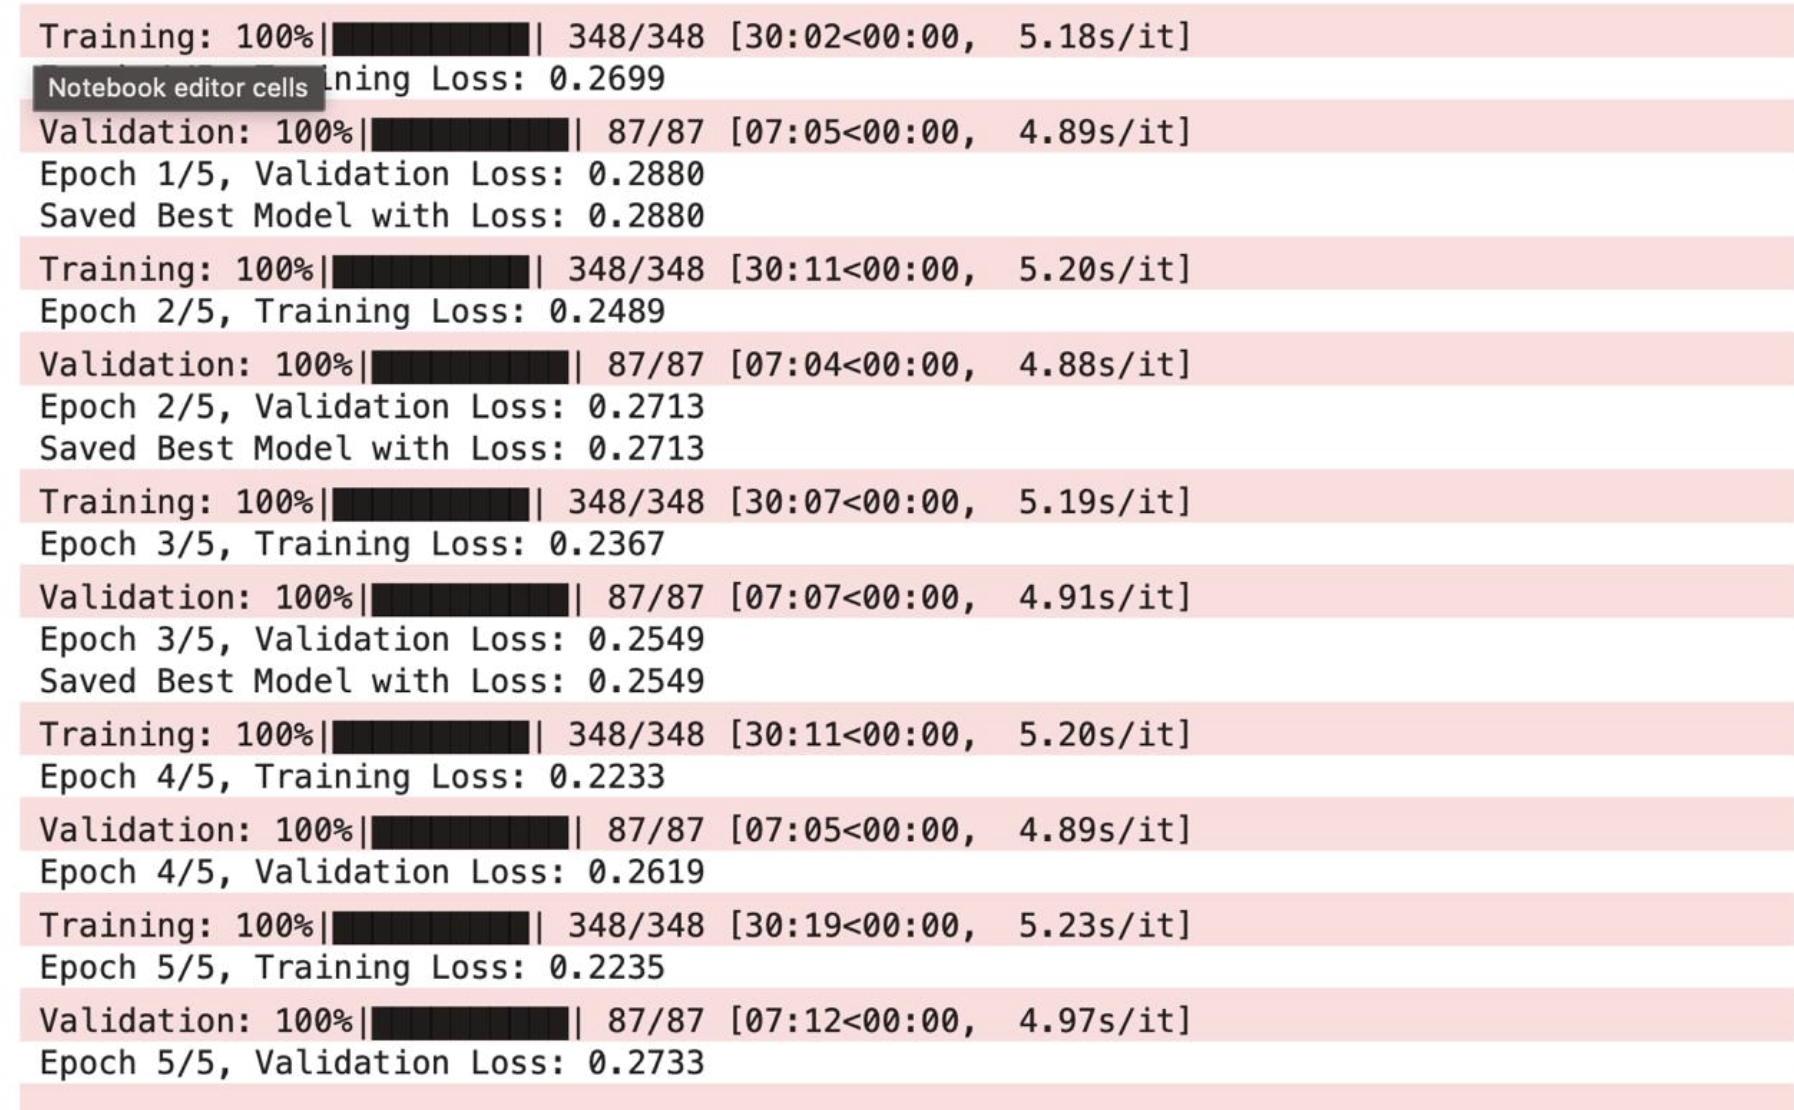


In [7]:
import torch
import segmentation_models_pytorch as smp
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,  
    in_channels=3,
    classes=10  
)


model.load_state_dict(torch.load('/kaggle/input/unet/pytorch/default/1/best_model.pth'))
model.eval()  
model = model.to('cuda')  

/tmp/ipykernel_30/402924435.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/unet/pytorch/default/1/best_model.pth'))
